In [1]:
import os
import sys

import numpy  as np
import tables as tb
import pandas as pd
import matplotlib
import math

#the line below makes the plot as a pop-up, that can be saved
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

In [2]:
import functions.histo_functions as myhf
import functions.efficiency_functions as myef

### Opening TRACK Files - Name 

In [3]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/'

#0nubb files
track_list_0nubb = []
max0nubbf = 900
filepath_0nubb_tracks = filepath+'0nubb/tracks/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb = filepath_0nubb_tracks+f'next100.0nubb.{nfile}.skel_tracks.R21mm.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks = pd.read_hdf(filename_0nubb, 'Tracks')
    except:
        print('File {} not good'.format(filename_0nubb))
        continue
        
    track_list_0nubb.append(readfile_tracks)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_0nubb = pd.concat([dt for dt in track_list_0nubb]) 
tracks_0nubb.columns  

#these are all the elements inside the file:

File /Users/halmamol/NEXT/files/NEXT100/0nubb/tracks/next100.0nubb.723.skel_tracks.R21mm.h5 not good


Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

In [4]:
#same for selectron files
track_list_selectron = []
maxselectron = 900
filepath_selectron_tracks = filepath+'selectron/tracks/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,maxselectron):
    
    filename_selectron = filepath_selectron_tracks+f'next100.e-_roi.{nfile}.skel_tracks.R21mm.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks_selectron = pd.read_hdf(filename_selectron, 'Tracks')
    except:
        print('File {} not good'.format(filename_selectron))
        continue
        
    track_list_selectron.append(readfile_tracks_selectron)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_selectron = pd.concat([dt for dt in track_list_selectron]) 
tracks_selectron.columns  

#these are all the elements inside the file:

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

### Checking variables

So far, I'm interested in selecting the events in/with:
- **Fiducial**: fiducial cut around the detector volume, of 2cm from the border
- **1Track**: in this case, considers the track with highest deposition
- **NoOverlap**: defined blobs in one trace should not overlap
- **ROI**: energy cut in the region of interest, between [2.445,2475]MeV

In [5]:
#Checking total amount of events, prior any selection
nevents_0nubb_total = tracks_0nubb.event.nunique()
print(f'Initial amount of events for 0nubb: {nevents_0nubb_total}')

nevents_selectron_total = tracks_selectron.event.nunique()
print(f'Initial amount of events for selectrons: {nevents_selectron_total}')

Initial amount of events for 0nubb: 8790
Initial amount of events for selectrons: 8800


### Checking variables: Fiducial

Test the position of the track end point, to see if it's withing the fiducial limits. To do so, I need the information about the NEXT100 dimensions:

In [6]:
#Dimensions for the NEXT100 detector
veto_N100 = 20 # mm
rmax_N100 = 492 - veto_N100
zmin_N100 = veto_N100
zmax_N100 = 1205 - veto_N100

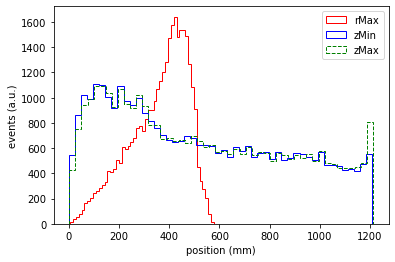

In [7]:
track_0nubb_rmax = tracks_0nubb.r_max
track_0nubb_zmin = tracks_0nubb.z_min
track_0nubb_zmax = tracks_0nubb.z_max

plt.hist(track_0nubb_rmax, bins = 50, color='red', histtype='step', label = 'rMax')
plt.hist(track_0nubb_zmin, bins = 50, color='blue', histtype='step', label = 'zMin')
plt.hist(track_0nubb_zmax, bins = 50, color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.legend(loc=1);
plt.show()

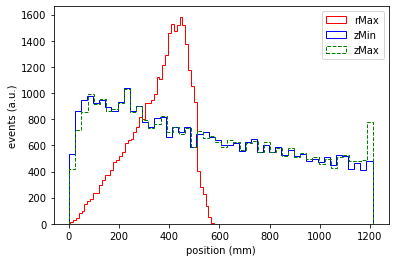

In [8]:
track_selectron_rmax = tracks_selectron.r_max
track_selectron_zmin = tracks_selectron.z_min
track_selectron_zmax = tracks_selectron.z_max

plt.hist(track_selectron_rmax, bins = 50, color='red', histtype='step', label = 'rMax')
plt.hist(track_selectron_zmin, bins = 50, color='blue', histtype='step', label = 'zMin')
plt.hist(track_selectron_zmax, bins = 50, color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.legend(loc=1);
plt.show()

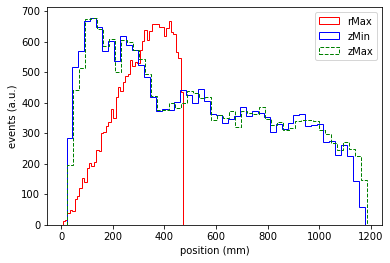

In [9]:
#For the evaluation of the events out of fiducial limits it's necessary to do several steps

#First, check a list of events where at least 1 trace is out of the limits:

nonfiducial_list_0nubb = tracks_0nubb[~((tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_0nubb = tracks_0nubb[(tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_0nubb    = ~fiducial_tracks_0nubb.event.isin(nonfiducial_list_0nubb) 

# And finally I select the events with an asigned True from the previous line 
tracks_0nubb_fiducial = fiducial_tracks_0nubb[evt_fid_sel_0nubb]

track_rmax = tracks_0nubb_fiducial.r_max
track_zmin = tracks_0nubb_fiducial.z_min
track_zmax = tracks_0nubb_fiducial.z_max

plt.hist(track_rmax, bins = 50, color='red', histtype='step', label = 'rMax')
plt.hist(track_zmin, bins = 50, color='blue', histtype='step', label = 'zMin')
plt.hist(track_zmax, bins = 50, color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.legend(loc=1);
plt.show()

In [10]:
#Now I do the same for single electron

nonfiducial_list_selectron = tracks_selectron[~((tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_selectron = tracks_selectron[(tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_selectron    = ~fiducial_tracks_selectron.event.isin(nonfiducial_list_selectron) 

# And finally I select the events with an asigned True from the previous line 
tracks_selectron_fiducial = fiducial_tracks_selectron[evt_fid_sel_selectron]

In [11]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_fiducial = tracks_0nubb_fiducial.event.nunique()
nevents_selectron_fiducial = tracks_selectron_fiducial.event.nunique()

print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {100*nevents_0nubb_fiducial/nevents_0nubb_total}%')
print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {100*nevents_selectron_fiducial/nevents_0nubb_total}%')
print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    8790        
FIDUCIAL   6076                ---      69.12400455062571%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    8790        
FIDUCIAL   6076                ---      66.17747440273038%
--------!--------------!----------------!----------------


### Checking variables: 1Track
To check the track with highest energy deposition: 1st check if there is more than 1track, later remove the ones with energy deposition. 

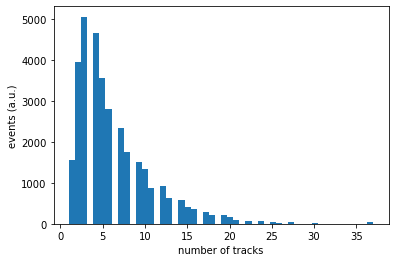

In [12]:
#Check the number of tracks with numb_of_tracks
ntracks = tracks_0nubb.numb_of_tracks

plt.hist(ntracks, bins = 50)
plt.xlabel('number of tracks')
plt.ylabel('events (a.u.)')
plt.show()


In [13]:
#Loop to study the number of tracks in the event, to take the one with max energy deposition
#Normally it would be asked that: 

#tracks_0nubb_1track = tracks_0nubb[tracks_0nubb.numb_of_tracks == 1]

#tracks_0nubb_1trackfid = tracks_0nubb_fiducial[tracks_0nubb_fiducial.numb_of_tracks == 1]

#But I'm going to take the traces with highest deposition. Checking this:
tracks_0nubb

#I've seen that the 1st track is the one with the highest energy deposition

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,2.475314,180.973722,739,27246,4,-259.5,-367.5,308.425500,...,333.410510,-254.025000,-226.000000,316.151619,0.373302,0.225996,0,4.961538,4.897436,4.904922
1,0,1,0.000343,0.000000,1,13,4,-286.5,-299.5,313.988219,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,0.373302,0.225996,-1,4.961538,4.897436,4.904922
2,0,2,0.000104,4.897436,2,4,4,-256.5,-282.5,334.031875,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,0.373302,0.225996,-1,4.961538,4.897436,4.904922
3,0,3,0.000052,0.000000,1,2,4,-158.5,-408.5,335.988812,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,0.373302,0.225996,-1,4.961538,4.897436,4.904922
0,1,0,0.953390,100.009867,465,16014,10,433.5,-201.5,85.224500,...,113.939352,464.083333,-187.703125,109.401530,0.217124,0.089520,0,4.928571,4.911765,4.649504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,8989,1,0.004963,31.163494,19,325,6,-475.5,235.5,1086.980625,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,0.278518,0.162548,-1,4.950000,4.939394,4.229917
2,8989,2,0.001251,20.115518,9,107,6,-394.5,207.5,1083.007625,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,0.278518,0.162548,-1,4.950000,4.939394,4.229917
3,8989,3,0.000822,20.104912,6,66,6,-449.5,97.5,1084.969250,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,0.278518,0.162548,-1,4.950000,4.939394,4.229917
4,8989,4,0.000270,4.939394,2,24,6,-395.5,238.5,1091.007875,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,0.278518,0.162548,-1,4.950000,4.939394,4.229917


In [14]:
#Therefore, I'm going to take the 1st 'trackID'
tracks_0nubb_1track = tracks_0nubb[tracks_0nubb.trackID == 0]
tracks_0nubb_1trackfid = tracks_0nubb_fiducial[tracks_0nubb_fiducial.trackID == 0]

tracks_selectron_1track = tracks_selectron[tracks_selectron.trackID == 0]
tracks_selectron_1trackfid = tracks_selectron_fiducial[tracks_selectron_fiducial.trackID == 0]

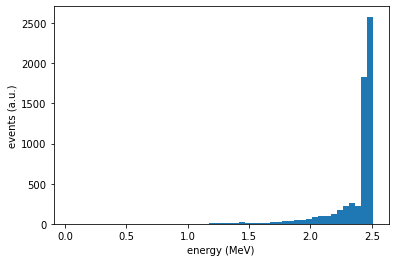

In [15]:
plt.hist(tracks_0nubb_1trackfid.energy, bins = 50)
plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.show()

In [16]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_1track = tracks_0nubb_1track.event.nunique()
nevents_0nubb_1trackfid = tracks_0nubb_1trackfid.event.nunique()

nevents_selectron_1track = tracks_selectron_1track.event.nunique()
nevents_selectron_1trackfid = tracks_selectron_1trackfid.event.nunique()

print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!----REDUCTION----!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}         {100*nevents_0nubb_fiducial/nevents_0nubb_total}% {100*nevents_0nubb_fiducial/nevents_0nubb_total}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {100*nevents_0nubb_1trackfid/nevents_0nubb_fiducial}% {100*nevents_0nubb_1trackfid/nevents_0nubb_total}%')
print('--------!--------------!------------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {100*nevents_selectron_fiducial/nevents_selectron_total}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {100*nevents_selectron_1trackfid/nevents_selectron_fiducial}% {100*nevents_selectron_1trackfid/nevents_selectron_total}%')
print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!----REDUCTION----!---EFFICIENCY---
INITIAL    8790        
FIDUCIAL   6076         69.12400455062571% 69.12400455062571%
1TRACK.    6076        100.0% 69.12400455062571%
--------!--------------!------------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    8800        
FIDUCIAL   5817                ---      66.10227272727273%
1TRACK.    5817        100.0% 66.10227272727273%
--------!--------------!----------------!----------------


### Checking variables: **NoOverlap**
The variable ovlp_blob_energy is defined for this purpouse

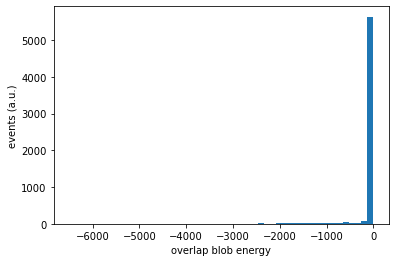

In [17]:
ovlp_blob_energy = tracks_0nubb_1trackfid.ovlp_blob_energy

plt.hist(ovlp_blob_energy, bins = 50)
plt.xlabel('overlap blob energy')
plt.ylabel('events (a.u.)')
plt.show()

In [18]:
#Getting ovlp variable of the tracks, and selecting events with no ovlp

tracks_0nubb_ovlp = tracks_0nubb[tracks_0nubb.ovlp_blob_energy == 0.]
tracks_0nubb_ovlp1trackfid = tracks_0nubb_1trackfid[tracks_0nubb_1trackfid.ovlp_blob_energy == 0.]

tracks_selectron_ovlp = tracks_selectron[tracks_selectron.ovlp_blob_energy == 0.]
tracks_selectron_ovlp1trackfid = tracks_selectron_1trackfid[tracks_selectron_1trackfid.ovlp_blob_energy == 0.]

In [19]:
#Checking total amount of events, after overlap selection

nevents_0nubb_ovlp = tracks_0nubb_ovlp.event.nunique()
nevents_0nubb_ovlp1trackfid = tracks_0nubb_ovlp1trackfid.event.nunique()

nevents_selectron_ovlp = tracks_selectron_ovlp.event.nunique()
nevents_selectron_ovlp1trackfid = tracks_selectron_ovlp1trackfid.event.nunique()



print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!----REDUCTION----!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}         {100*nevents_0nubb_fiducial/nevents_0nubb_total}% {100*nevents_0nubb_fiducial/nevents_0nubb_total}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {100*nevents_0nubb_1trackfid/nevents_0nubb_fiducial}% {100*nevents_0nubb_1trackfid/nevents_0nubb_total}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_1trackfid}%   {100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_total}%')
print('--------!--------------!------------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {100*nevents_selectron_fiducial/nevents_selectron_total}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {100*nevents_selectron_1trackfid/nevents_selectron_fiducial}% {100*nevents_selectron_1trackfid/nevents_selectron_total}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {100*nevents_selectron_ovlp1trackfid/nevents_selectron_1trackfid}%   {100*nevents_selectron_ovlp1trackfid/nevents_selectron_total}%')
print('--------!--------------!----------------!----------------')

--------------------------0nubb-------------------------
--CUT---!----EVENTS----!----REDUCTION----!---EFFICIENCY---
INITIAL    8790        
FIDUCIAL   6076         69.12400455062571% 69.12400455062571%
1TRACK.    6076        100.0% 69.12400455062571%
OVLP       5428        89.33508887425938%   61.75199089874858%
--------!--------------!------------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    8800        
FIDUCIAL   5817                ---      66.10227272727273%
1TRACK.    5817        100.0% 66.10227272727273%
OVLP       5606        96.37270070483066%   63.70454545454545%
--------!--------------!----------------!----------------


### Checking variables: ROI
Getting events with an energy inside the region of interest.

In [20]:
#Limits of the Energy ROI 

emin = 2.4
emax = 2.54

#UPDATE: The initial values are not the used ones. Due to some spread in the reconstructed
#energy, and some non-linearities, the ROI needs to be broader. Values are increased as above.

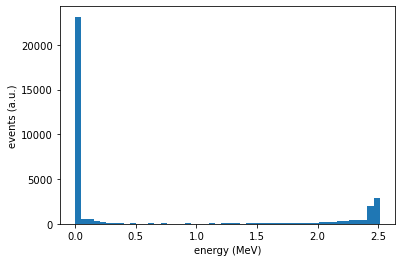

In [21]:
#Getting energy of the tracks
energy = tracks_0nubb.energy

plt.hist(energy, bins = 50)
plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.show()

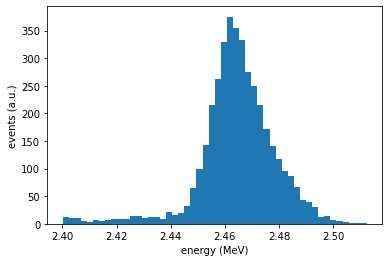

In [22]:
#Selecting events in the ROI
tracks_0nubb_ROI = tracks_0nubb[(tracks_0nubb.energy >= emin) & (tracks_0nubb.energy <= emax)]
tracks_0nubb_ROIovlp1trackfid = tracks_0nubb_ovlp1trackfid[(tracks_0nubb_ovlp1trackfid.energy >= emin) & (tracks_0nubb_ovlp1trackfid.energy <= emax)]

tracks_selectron_ROI = tracks_selectron[(tracks_selectron.energy >= emin) & (tracks_selectron.energy <= emax)]
tracks_selectron_ROIovlp1trackfid = tracks_selectron_ovlp1trackfid[(tracks_selectron_ovlp1trackfid.energy >= emin) & (tracks_selectron_ovlp1trackfid.energy <= emax)]


energy = tracks_0nubb_ROIovlp1trackfid.energy

plt.hist(energy, bins = 50)
plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.show()

In [23]:
#Checking total amount of events, after ROI selection
nevents_0nubb_ROI = tracks_0nubb_ROI.event.nunique()
nevents_0nubb_ROIovlp1trackfid = tracks_0nubb_ROIovlp1trackfid.event.nunique()

nevents_selectron_ROI = tracks_selectron_ROI.event.nunique()
nevents_selectron_ROIovlp1trackfid = tracks_selectron_ROIovlp1trackfid.event.nunique()


print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!----REDUCTION----!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}         {100*nevents_0nubb_fiducial/nevents_0nubb_total}% {100*nevents_0nubb_fiducial/nevents_0nubb_total}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {100*nevents_0nubb_1trackfid/nevents_0nubb_fiducial}% {100*nevents_0nubb_1trackfid/nevents_0nubb_total}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_1trackfid}%   {100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_total}%')
print(f'ROI        {nevents_0nubb_ROIovlp1trackfid}        {100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_ovlp1trackfid}%   {100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_total}%')
print('--------!--------------!------------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {100*nevents_selectron_fiducial/nevents_selectron_total}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {100*nevents_selectron_1trackfid/nevents_selectron_fiducial}% {100*nevents_selectron_1trackfid/nevents_selectron_total}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {100*nevents_selectron_ovlp1trackfid/nevents_selectron_1trackfid}%   {100*nevents_selectron_ovlp1trackfid/nevents_selectron_total}%')
print(f'ROI        {nevents_selectron_ROIovlp1trackfid}        {100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_ovlp1trackfid}%   {100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_total}%')
print('--------!--------------!----------------!----------------')

--------------------------0nubb-------------------------
--CUT---!----EVENTS----!----REDUCTION----!---EFFICIENCY---
INITIAL    8790        
FIDUCIAL   6076         69.12400455062571% 69.12400455062571%
1TRACK.    6076        100.0% 69.12400455062571%
OVLP       5428        89.33508887425938%   61.75199089874858%
ROI        4004        73.7656595431098%   45.551763367463025%
--------!--------------!------------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    8800        
FIDUCIAL   5817                ---      66.10227272727273%
1TRACK.    5817        100.0% 66.10227272727273%
OVLP       5606        96.37270070483066%   63.70454545454545%
ROI        3803        67.83803068141277%   43.21590909090909%
--------!--------------!----------------!----------------


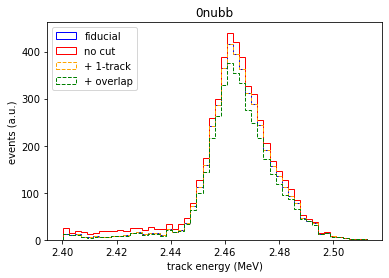

In [24]:
tracks_0nubb_sel = tracks_0nubb[tracks_0nubb.energy > 2.4]
tracks_0nubb_fiducial_sel = tracks_0nubb_fiducial[tracks_0nubb_fiducial.energy > 2.4]
tracks_0nubb_1trackfid_sel = tracks_0nubb_1trackfid[tracks_0nubb_1trackfid.energy > 2.4]
tracks_0nubb_ovlp1trackfid_sel = tracks_0nubb_ovlp1trackfid[tracks_0nubb_ovlp1trackfid.energy > 2.4]
tracks_0nubb_ROIovlp1trackfid_sel = tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.energy > 2.4]

plt.hist(tracks_0nubb_fiducial_sel.energy, bins = 50, color='blue', histtype='step', label = 'fiducial')
plt.hist(tracks_0nubb_sel.energy, bins = 50, color='red', histtype='step', label = 'no cut')
plt.hist(tracks_0nubb_1trackfid_sel.energy, bins = 50, color='orange', histtype='step', label = '+ 1-track', linestyle='dashed')
plt.hist(tracks_0nubb_ovlp1trackfid_sel.energy, bins = 50, color='green', histtype='step', label = '+ overlap', linestyle='dashed')
#plt.hist(tracks_0nubb_ROIovlp1trackfid_sel.energy, bins = 50, color='purple', histtype='step', label = '+ ROI', linestyle='dashed')

plt.xlabel('track energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=2);
#plt.xlim((2.2,2.6))
#plt.yscale('log')
plt.show()

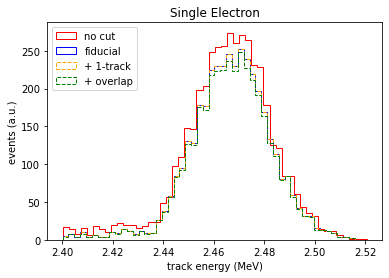

In [25]:
tracks_selectron_sel = tracks_selectron[tracks_selectron.energy > 2.4]
tracks_selectron_fiducial_sel = tracks_selectron_fiducial[tracks_selectron_fiducial.energy > 2.4]
tracks_selectron_1trackfid_sel = tracks_selectron_1trackfid[tracks_selectron_1trackfid.energy > 2.4]
tracks_selectron_ovlp1trackfid_sel = tracks_selectron_ovlp1trackfid[tracks_selectron_ovlp1trackfid.energy > 2.4]
tracks_selectron_ROIovlp1trackfid_sel = tracks_selectron_ROIovlp1trackfid[tracks_selectron_ROIovlp1trackfid.energy > 2.4]

plt.hist(tracks_selectron_sel.energy, bins = 50, color='red', histtype='step', label = 'no cut')
plt.hist(tracks_selectron_fiducial_sel.energy, bins = 50, color='blue', histtype='step', label = 'fiducial')
plt.hist(tracks_selectron_1trackfid_sel.energy, bins = 50, color='orange', histtype='step', label = '+ 1-track', linestyle='dashed')
plt.hist(tracks_selectron_ovlp1trackfid_sel.energy, bins = 50, color='green', histtype='step', label = '+ overlap', linestyle='dashed')
#plt.hist(tracks_selectron_ROIovlp1trackfid_sel.energy, bins = 50, color='purple', histtype='step', label = '+ ROI', linestyle='dashed')


plt.xlabel('track energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=2);
#plt.xlim((2.,2.6))
#plt.yscale('log')
plt.show()

Text(0.5, 1.0, 'Cut efficiency')

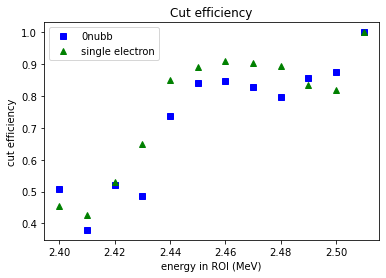

In [26]:
energybin = []
events_energybin_notcuts_0nubb, events_energybin_notcuts_selectron= [], []
events_energybin_fiducial_0nubb, events_energybin_fiducial_selectron= [], []
events_energybin_all_0nubb, events_energybin_all_selectron= [], []

cutefficiency_tot_0nubb, cutefficiency_tot_selectron= [], []
cutefficiency_fiducial_0nubb, cutefficiency_fiducial_selectron= [], []

nenergybin = 2.40
steps = 0.01


while nenergybin < 2.51:
    energybin.append(nenergybin)
    events_energybin_notcuts_0nubb.append(tracks_0nubb[(tracks_0nubb.energy > nenergybin) & 
                                (tracks_0nubb.energy < nenergybin+steps)].event.nunique())
    events_energybin_fiducial_0nubb.append(tracks_0nubb_fiducial[(tracks_0nubb_fiducial.energy > nenergybin) & 
                                (tracks_0nubb_fiducial.energy < nenergybin+steps)].event.nunique())
    events_energybin_all_0nubb.append(tracks_0nubb_ROIovlp1trackfid[(tracks_0nubb_ROIovlp1trackfid.energy > nenergybin) & 
                                (tracks_0nubb_ROIovlp1trackfid.energy < nenergybin+steps)].event.nunique())
    events_energybin_notcuts_selectron.append(tracks_selectron[(tracks_selectron.energy > nenergybin) & 
                                (tracks_selectron.energy < nenergybin+steps)].event.nunique())
    events_energybin_all_selectron.append(tracks_selectron_ROIovlp1trackfid[(tracks_selectron_ROIovlp1trackfid.energy > nenergybin) & 
                                (tracks_selectron_ROIovlp1trackfid.energy < nenergybin+steps)].event.nunique())
    nenergybin = nenergybin + steps


events_energybin_all_0nubb=np.array(events_energybin_all_0nubb, dtype=np.float)
events_energybin_fiducial_0nubb=np.array(events_energybin_fiducial_0nubb, dtype=np.float)
events_energybin_notcuts_0nubb=np.array(events_energybin_notcuts_0nubb, dtype=np.float)


events_energybin_all_selectron=np.array(events_energybin_all_selectron, dtype=np.float)
events_energybin_notcuts_selectron=np.array(events_energybin_notcuts_selectron, dtype=np.float)

cutefficiency_tot_0nubb = events_energybin_all_0nubb/events_energybin_notcuts_0nubb
cutefficiency_tot_selectron = events_energybin_all_selectron/events_energybin_notcuts_selectron
cutefficiency_fiducial_0nubb = events_energybin_fiducial_0nubb/events_energybin_notcuts_0nubb

fig, ax = plt.subplots()
ax.plot(energybin,cutefficiency_tot_0nubb, 'bs', label='0nubb')
ax.plot(energybin,cutefficiency_tot_selectron, 'g^', label='single electron')

leg = ax.legend();
plt.xlabel('energy in ROI (MeV)')
plt.ylabel('cut efficiency')
plt.title('Cut efficiency')

Text(0, 0.5, 'signal efficiency (0nubb)')

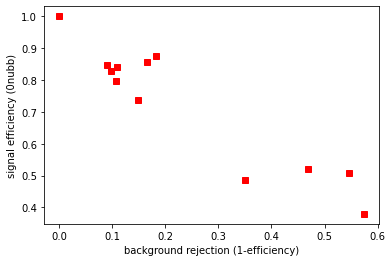

In [27]:
fig, ax = plt.subplots()
ax.plot(1-cutefficiency_tot_selectron,cutefficiency_tot_0nubb, 'rs')
plt.xlabel('background rejection (1-efficiency)')
plt.ylabel('signal efficiency (0nubb)')
#plt.title('Cut efficiency')

### 1 - Representing TRUE vs RECO

Now I'm going to see if I can represent for an event the comparison between the reconstructed track and the true information from the MC simulation. 

In [28]:
#0nubb files
hits_list_0nubb = []
filepath_0nubb_hits = filepath+'0nubb/hits/'


filename_0nubb_hits = filepath_0nubb_hits+f'next100.0nubb.1.deconv.h5'
h5file = tb.open_file(filename_0nubb_hits)
h5file

File(filename=/Users/halmamol/NEXT/files/NEXT100/0nubb/hits/next100.0nubb.1.deconv.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/DECO (Group) ''
/DECO/Events (Table(254988,), shuffle, zlib(4)) 'Deconvolved hits'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "npeak": UInt64Col(shape=(), dflt=0, pos=1),
  "X": Float64Col(shape=(), dflt=0.0, pos=2),
  "Y": Float64Col(shape=(), dflt=0.0, pos=3),
  "Z": Float64Col(shape=(), dflt=0.0, pos=4),
  "E": Float64Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (1365,)
  autoindex := True
  colindexes := {
    "event": Index(6, medium, shuffle, zlib(1)).is_csi=False}
/MC (Group) ''
/MC/configuration (Table(41,), shuffle, zlib(4)) ''
  description := {
  "param_key": StringCol(itemsize=300, shape=(), dflt=b'', pos=0),
  "param_value": StringCol(itemsize=300, shape=(), dflt

The true information is stored in MC, more concretely inside the 'particles' group. To check the true position is going to be more complicated than to retrieve the info from a variable. I'm going to use the information from "plot_blobs_with_true_extremes_beersheba.py" as a baseline to construct the true information. I'll start with 0nubb, and I'll extrapolate the information to SE later on. 

In [29]:
#0nubb files
true_list_0nubb = []
filepath_0nubb_true = filepath+'0nubb/hits/'

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb_true = filepath_0nubb_true+f'next100.0nubb.{nfile}.deconv.h5'

    try:
        readfile_true_0nubb = pd.read_hdf(filename_0nubb_true, 'MC/particles')
    except:
        print('File {} not good'.format(filename_0nubb_true))
        continue
        
    true_list_0nubb.append(readfile_true_0nubb)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_0nubb = pd.concat([dt for dt in true_list_0nubb]) 
true_0nubb.columns  

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

Inside of MC/particles you can find all the information about the created partiles. Right now, I need to check the primary particles created in the simulation: the two electrons. To do so, I need to check the information about the 'primary' variable

In [30]:
true_0nubb_primary = true_0nubb[true_0nubb.primary == True]
true_0nubb_primary

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
9,0,2,e-,True,0,-239.914810,-238.046280,316.365936,0.0,-200.825760,...,2.549860,0.109969,0.684162,0.0,0.0,-0.0,2.180298,235.106247,none,Scintillation
10,0,1,e-,True,0,-239.914810,-238.046280,316.365936,0.0,-240.744125,...,-0.013486,-0.226322,-0.556109,-0.0,0.0,-0.0,0.277532,17.443966,none,Scintillation
14,1,2,e-,True,0,452.146729,-166.560150,96.130058,0.0,457.095093,...,-0.406067,1.022711,0.653254,-0.0,-0.0,0.0,0.866930,63.153664,none,Scintillation
16,1,1,e-,True,0,452.146729,-166.560150,96.130058,0.0,469.336273,...,-0.455509,0.328598,-1.959947,-0.0,0.0,0.0,1.590900,56.679573,none,Scintillation
19,2,2,e-,True,0,157.780060,-127.197853,787.558777,0.0,165.998825,...,-0.259671,1.266991,-0.398611,0.0,0.0,0.0,0.935620,58.765797,none,Scintillation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,8987,1,e-,True,0,319.647125,256.603302,706.949097,0.0,292.450134,...,0.041772,0.326389,-2.535808,0.0,-0.0,0.0,2.096628,180.334976,none,Scintillation
282,8988,2,e-,True,0,-401.094818,3.905844,214.294266,0.0,-406.265930,...,0.132052,1.330568,0.311546,-0.0,-0.0,0.0,0.953934,88.180252,none,Scintillation
286,8988,1,e-,True,0,-401.094818,3.905844,214.294266,0.0,-396.048065,...,-0.084179,-1.736119,-0.881752,-0.0,-0.0,0.0,1.503896,134.865463,none,Scintillation
287,8989,2,e-,True,0,-432.714722,192.933319,1094.687134,0.0,-444.201263,...,-0.840328,0.122159,-0.132181,-0.0,0.0,-0.0,0.488834,28.419731,none,Scintillation


The primary particles are separated by 'particle_id' 1 and 2, and this information will allow us to differenciate between blob1 and/or 2. 

In [31]:
true_0nubb_primary_part1 = true_0nubb_primary[true_0nubb_primary.particle_id == 1]
true_0nubb_primary_part2 = true_0nubb_primary[true_0nubb_primary.particle_id == 2]

In [32]:
true_0nubb_event0 = true_0nubb[true_0nubb.event_id == 0]
true_0nubb_event0

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,0,14743383,gamma,False,2,-198.271820,-256.607605,311.145691,0.218630,-198.084488,...,0.003226,-0.001909,-0.001354,0.0,-0.0,-0.0,0.003986,0.231452,eBrem,phot
1,0,14854918,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084457,...,0.006188,0.003036,0.001210,-0.0,0.0,0.0,0.000048,0.000024,phot,Scintillation
2,0,14854917,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084488,...,-0.001329,0.006434,0.002097,-0.0,-0.0,-0.0,0.000047,0.000050,phot,Scintillation
3,0,14854916,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084488,...,-0.000592,-0.006582,-0.001970,0.0,0.0,0.0,0.000047,0.000024,phot,Scintillation
4,0,14854915,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084656,...,-0.015960,0.015451,0.008377,-0.0,-0.0,-0.0,0.000551,0.000985,phot,Scintillation
5,0,14854914,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.084427,...,0.007276,0.001941,0.010619,0.0,0.0,0.0,0.000166,0.000317,phot,Scintillation
6,0,14854913,e-,False,14743383,-198.084488,-256.718475,311.067047,0.219402,-198.085205,...,-0.038018,-0.038454,-0.014558,0.0,0.0,0.0,0.003059,0.013139,phot,Scintillation
7,0,29046889,e-,False,2,-196.871140,-288.876251,321.973602,0.430943,-197.021393,...,-0.211537,-0.017156,0.079031,-0.0,0.0,0.0,0.047936,1.375517,eIoni,Scintillation
8,0,56290415,e-,False,2,-199.225845,-347.134033,334.436646,0.793654,-199.606995,...,0.204526,0.016255,-0.331930,0.0,-0.0,-0.0,0.131957,5.372118,eIoni,Scintillation
9,0,2,e-,True,0,-239.914810,-238.046280,316.365936,0.000000,-200.825760,...,2.549860,0.109969,0.684162,0.0,0.0,-0.0,2.180298,235.106247,none,Scintillation


In [33]:
tracks_0nubb_ROIovlp1trackfid

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,2.475314,180.973722,739,27246,4,-259.5,-367.5,308.425500,...,333.410510,-254.025000,-226.000000,316.151619,0.373302,0.225996,0,4.961538,4.897436,4.904922
0,2,0,2.445390,102.110604,714,25383,1,99.5,-143.5,782.350812,...,831.606715,162.409091,-134.000000,788.508176,0.749118,0.455082,0,4.833333,4.727273,4.940760
0,4,0,2.489506,133.095559,742,26827,1,-452.5,-77.5,641.252813,...,706.292077,-415.750000,-52.666667,649.386413,0.658333,0.657268,0,4.909091,4.857143,4.744351
0,6,0,2.474666,120.271862,705,25458,2,23.5,-413.5,825.211250,...,888.536990,34.888889,-379.000000,831.376995,0.893941,0.536796,0,4.950000,4.750000,4.900092
0,7,0,2.463006,134.762404,745,25910,2,-306.5,149.5,402.317125,...,471.493537,-294.576923,172.444444,408.390072,0.543604,0.185250,0,4.812500,4.850000,4.953477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,8964,0,2.466963,113.124441,583,20884,2,-406.5,151.5,178.344344,...,245.557057,-377.357143,216.000000,182.579834,0.697808,0.599744,0,4.958333,4.750000,4.713008
0,8972,0,2.488552,111.624460,704,27901,1,17.5,347.5,878.217375,...,884.485560,41.000000,366.909091,923.973518,0.831530,0.804395,0,5.000000,4.894737,4.883577
0,8977,0,2.467101,126.452604,857,29865,2,-389.5,87.5,598.237687,...,625.068378,-378.261905,143.980000,649.462154,0.777076,0.415310,0,4.916667,4.892857,4.790557
0,8986,0,2.456252,123.549826,909,30703,1,-46.5,15.5,882.284750,...,895.992758,-32.083333,52.777778,903.962852,0.522082,0.444524,0,4.909091,4.692308,4.491625


Now I'm going to do a loop over all the events in both reco and true, and I'm going to obtain the difference for each of them. 

Several things need to be taken into account at this stage:
- After all the selection process, not all the events are contained in 'tracks_0nubb_ROIovlp1trackfid', need to select only the events in the loop that are included in 'tracks_0nubb_ROIovlp1trackfid'
- For 0nubb, the true end points of the track are the variables **final_x/y/z** from the primary particles. **initial_x/y/z** correspond to the original position of the desintegration. 
- The true/reco information from the tables are given in terms of arrays. First, in order to get the value from a variable, it's necessary to ask for "values". Later on, when doing the comparison, it's necessary to force the term to turn into float before assign them into the 'diff' element. 
- Last but definately, not least, what it's defined as blob1 or blob2 is not necessarily the information about particle 1 or 2 respectively. Blobs are tagged as the deposited energy in the detector. So when the reco vs true comparison is made, it's important to re-define what's 1 or 2 for the blobs. In the following boxes I've done some tests in order to see how I can tag each of the events. 

In [34]:
d_rt_11, d_rt_12, d_rr_12, d_tt_12, D_tt_12, x_t_1, y_t_1, x_t_2, y_t_2, r_t_1, r_t_2, z_t_1, z_t_2 = [], [], [], [], [], [], [],[], [], [],[], [], []

for nevt in range(1,true_0nubb.event_id.nunique()):
    
    if nevt not in tracks_0nubb_ROIovlp1trackfid.event.unique():
        continue
        
    true_0nubb_x_p1 = float(true_0nubb_primary_part1[true_0nubb_primary_part1.event_id == nevt].final_x.values)
    true_0nubb_y_p1 = float(true_0nubb_primary_part1[true_0nubb_primary_part1.event_id == nevt].final_y.values)
    true_0nubb_z_p1 = float(true_0nubb_primary_part1[true_0nubb_primary_part1.event_id == nevt].final_z.values)

    true_0nubb_x_p2 = float(true_0nubb_primary_part2[true_0nubb_primary_part2.event_id == nevt].final_x.values)
    true_0nubb_y_p2 = float(true_0nubb_primary_part2[true_0nubb_primary_part2.event_id == nevt].final_y.values)
    true_0nubb_z_p2 = float(true_0nubb_primary_part2[true_0nubb_primary_part2.event_id == nevt].final_z.values)
    
    true_0nubb_r_p1 = math.sqrt(true_0nubb_x_p1*true_0nubb_x_p1+true_0nubb_y_p1*true_0nubb_y_p1)
    true_0nubb_r_p2 = math.sqrt(true_0nubb_x_p2*true_0nubb_x_p2+true_0nubb_y_p2*true_0nubb_y_p2)

    reco_0nubb_x_blob1 = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob1_x.values)
    reco_0nubb_y_blob1 = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob1_y.values)
    reco_0nubb_z_blob1 = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob1_z.values)
    
    reco_0nubb_x_blob2 = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob2_x.values)
    reco_0nubb_y_blob2 = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob2_y.values)
    reco_0nubb_z_blob2 = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob2_z.values)
    
    reco_0nubb_r_blob1 = math.sqrt(reco_0nubb_x_blob1*reco_0nubb_x_blob1+reco_0nubb_y_blob1*reco_0nubb_y_blob1)
    reco_0nubb_r_blob2 = math.sqrt(reco_0nubb_x_blob2*reco_0nubb_x_blob2+reco_0nubb_y_blob2*reco_0nubb_y_blob2)
    
   
    d_tt_12.append(math.sqrt((true_0nubb_x_p2-true_0nubb_x_p1)**2+(true_0nubb_y_p2-true_0nubb_y_p1)**2+(true_0nubb_z_p2-true_0nubb_z_p1)**2))
    d_rr_12.append(math.sqrt((reco_0nubb_x_blob1-reco_0nubb_x_blob2)**2+(reco_0nubb_y_blob1-reco_0nubb_y_blob2)**2+(reco_0nubb_z_blob1-reco_0nubb_z_blob2)**2))
    
    x_t_1.append(true_0nubb_x_p1)
    x_t_2.append(true_0nubb_x_p2)
    y_t_1.append(true_0nubb_y_p1)
    y_t_2.append(true_0nubb_y_p2)
    r_t_1.append(true_0nubb_r_p1)
    r_t_2.append(true_0nubb_r_p2)
    z_t_1.append(true_0nubb_z_p1)
    z_t_2.append(true_0nubb_z_p2)
    

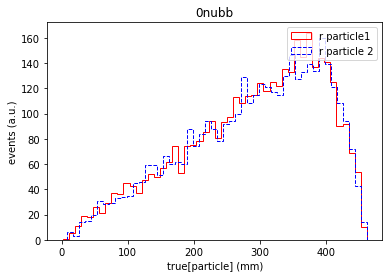

In [35]:
plt.hist(r_t_1, bins = 50, color='red', histtype='step', label = 'r particle1')
plt.hist(r_t_2, bins = 50, color='blue', histtype='step', label = 'r particle 2', linestyle='dashed')

plt.xlabel('true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

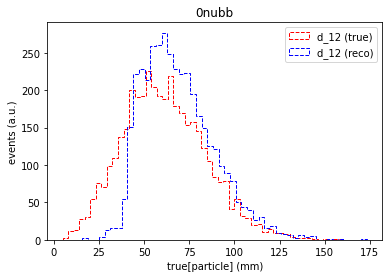

Mean distance between true particles 61.30707720299237
Mean distance between reco particles 69.00641980484117


In [36]:
plt.hist(d_tt_12, bins = 50, color='red', histtype='step', label = 'd_12 (true)', linestyle='dashed')
plt.hist(d_rr_12, bins = 50, color='blue', histtype='step', label = 'd_12 (reco)', linestyle='dashed')

plt.xlabel('true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

print(f'Mean distance between true particles {np.mean(d_tt_12)}')
print(f'Mean distance between reco particles {np.mean(d_rr_12)}')


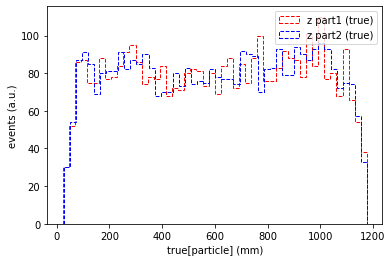

In [37]:
plt.hist(z_t_1, bins = 50, color='red', histtype='step', label = 'z part1 (true)', linestyle='dashed')
plt.hist(z_t_2, bins = 50, color='blue', histtype='step', label = 'z part2 (true)', linestyle='dashed')

plt.xlabel('true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.legend(loc=1);
plt.show()

On average, the distance between particles is around 30mm, so I'm going to look for blobs around the position of part1/2 + 30mm (approximately)

In [38]:
diff_b1_x_0nubb, diff_b1_y_0nubb, diff_b1_z_0nubb = [], [], []
diff_b2_x_0nubb, diff_b2_y_0nubb, diff_b2_z_0nubb = [], [], []

diff_b1_x_0nubb_test, diff_b1_y_0nubb_test, diff_b1_z_0nubb_test = [], [], []
diff_b2_x_0nubb_test, diff_b2_y_0nubb_test, diff_b2_z_0nubb_test = [], [], []

reco_0nubb_e, reco_0nubb_e_track, reco_0nubb_e_blob1, reco_0nubb_e_blob2 = [], [], [], []

totalevents, events12AB, events12BA, eventsNA = 0, 0, 0, 0

direction12, direction21 = False, False

for nevt in range(1,true_0nubb.event_id.nunique()):
    
    if nevt not in tracks_0nubb_ROIovlp1trackfid.event.unique():
        continue
        
    true_0nubb_x_pA = float(true_0nubb_primary_part1[true_0nubb_primary_part1.event_id == nevt].final_x.values)
    true_0nubb_y_pA = float(true_0nubb_primary_part1[true_0nubb_primary_part1.event_id == nevt].final_y.values)
    true_0nubb_z_pA = float(true_0nubb_primary_part1[true_0nubb_primary_part1.event_id == nevt].final_z.values)

    true_0nubb_x_pB = float(true_0nubb_primary_part2[true_0nubb_primary_part2.event_id == nevt].final_x.values)
    true_0nubb_y_pB = float(true_0nubb_primary_part2[true_0nubb_primary_part2.event_id == nevt].final_y.values)
    true_0nubb_z_pB = float(true_0nubb_primary_part2[true_0nubb_primary_part2.event_id == nevt].final_z.values)
    
    
    reco_0nubb_x_blobA = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob1_x.values)
    reco_0nubb_y_blobA = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob1_y.values)
    reco_0nubb_z_blobA = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob1_z.values)
    
    reco_0nubb_x_blobB = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob2_x.values)
    reco_0nubb_y_blobB = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob2_y.values)
    reco_0nubb_z_blobB = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].blob2_z.values)
    
    reco_0nubb_e_blobA = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].eblob1.values)
    reco_0nubb_e_blobB = float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].eblob2.values)

    reco_0nubb_e_track.append(float(tracks_0nubb_ROIovlp1trackfid[tracks_0nubb_ROIovlp1trackfid.event == nevt].energy.values))
    
    
    R_12 = math.sqrt((true_0nubb_x_p2-true_0nubb_x_p1)**2+(true_0nubb_y_p2-true_0nubb_y_p1)**2+(true_0nubb_z_p2-true_0nubb_z_p1)**2)/2
    R_AB = math.sqrt((reco_0nubb_x_blobA-reco_0nubb_x_blobB)**2+(reco_0nubb_y_blobA-reco_0nubb_y_blobB)**2+(reco_0nubb_z_blobA-reco_0nubb_z_blobB)**2)/2
    d_A1 = math.sqrt((true_0nubb_x_p1-reco_0nubb_x_blobA)**2+(true_0nubb_y_p1-reco_0nubb_y_blobA)**2+(true_0nubb_z_p1-reco_0nubb_z_blobA)**2)
    d_B1 = math.sqrt((true_0nubb_x_p1-reco_0nubb_x_blobB)**2+(true_0nubb_y_p1-reco_0nubb_y_blobB)**2+(true_0nubb_z_p1-reco_0nubb_z_blobB)**2)
    d_A2 = math.sqrt((true_0nubb_x_p2-reco_0nubb_x_blobA)**2+(true_0nubb_y_p2-reco_0nubb_y_blobA)**2+(true_0nubb_z_p2-reco_0nubb_z_blobA)**2)
    d_B2 = math.sqrt((true_0nubb_x_p2-reco_0nubb_x_blobB)**2+(true_0nubb_y_p2-reco_0nubb_y_blobB)**2+(true_0nubb_z_p2-reco_0nubb_z_blobB)**2)
    
    diff_b1_x_0nubb.append(reco_0nubb_x_blobA - true_0nubb_x_p1)
    diff_b1_y_0nubb.append(reco_0nubb_y_blobA - true_0nubb_y_p1)
    
    diff_b2_x_0nubb.append(reco_0nubb_x_blobB - true_0nubb_x_p2)
    diff_b2_y_0nubb.append(reco_0nubb_y_blobB - true_0nubb_y_p2)
    
    #print(f'R_12 = {R_12}')
    #print(f'R_AB = {R_AB}')
    #print(f'd_A1 = {d_A1}')
    #print(f'd_A2 = {d_A2}')
    #print(f'd_B1 = {d_B1}')
    #print(f'd_B2 = {d_B2}')
    
    totalevents = totalevents+1

    
    if abs(d_A1<R_12) or abs(d_B2<R_12):
        events12AB = events12AB+1
        direction12 = True
        #print('direction A1 B2')
    elif abs(d_A2<R_12) or abs(d_B1<R_12):
        events12BA = events12BA+1
        #print('direction A2 B1')
        direction21 = True
    elif d_A1<d_B1 and d_A2 and d_B2:
        events12AB = events12AB+1
        #print('direction A1 B2')
        direction12 = True
    elif d_B2<d_B1 and d_A2 and d_A1:
        events12AB = events12AB+1
        #print('direction A1 B2')
        direction12 = True
    elif d_A2<d_B1 and d_A1 and d_B2:
        events12BA = events12BA+1
        #print('direction A2 B1')
        direction21 = True
    elif d_B1<d_B2 and d_A1 and d_A2:
        events12BA = events12BA+1
        direction21 = True
        #print('direction A2 B1')
    else:
        eventsNA = eventsNA+1
        
    if (direction12 == True) & (reco_0nubb_e_blobA > reco_0nubb_e_blobB):
        reco_0nubb_x_blob1 = reco_0nubb_x_blobA
        reco_0nubb_y_blob1 = reco_0nubb_y_blobA
        reco_0nubb_z_blob1 = reco_0nubb_z_blobA
        
        reco_0nubb_x_blob2 = reco_0nubb_x_blobB
        reco_0nubb_y_blob2 = reco_0nubb_y_blobB
        reco_0nubb_z_blob2 = reco_0nubb_z_blobB
    
        true_0nubb_x_p1 = true_0nubb_x_pA
        true_0nubb_y_p1 = true_0nubb_y_pA
        true_0nubb_z_p1 = true_0nubb_z_pA
        
        true_0nubb_x_p2 = true_0nubb_x_pB
        true_0nubb_y_p2 = true_0nubb_y_pB
        true_0nubb_z_p2 = true_0nubb_z_pB
        
        reco_0nubb_e_blob1.append(reco_0nubb_e_blobA)
        reco_0nubb_e_blob2.append(reco_0nubb_e_blobB)

    elif (direction12 == True) & (reco_0nubb_e_blobA < reco_0nubb_e_blobB):
        reco_0nubb_x_blob1 = reco_0nubb_x_blobB
        reco_0nubb_y_blob1 = reco_0nubb_y_blobB
        reco_0nubb_z_blob1 = reco_0nubb_z_blobB
        
        reco_0nubb_x_blob2 = reco_0nubb_x_blobA
        reco_0nubb_y_blob2 = reco_0nubb_y_blobA
        reco_0nubb_z_blob2 = reco_0nubb_z_blobA
    
        true_0nubb_x_p1 = true_0nubb_x_pB
        true_0nubb_y_p1 = true_0nubb_y_pB
        true_0nubb_z_p1 = true_0nubb_z_pB
        
        true_0nubb_x_p2 = true_0nubb_x_pA
        true_0nubb_y_p2 = true_0nubb_y_pA
        true_0nubb_z_p2 = true_0nubb_z_pA
        
        reco_0nubb_e_blob1.append(reco_0nubb_e_blobB)
        reco_0nubb_e_blob2.append(reco_0nubb_e_blobA)
        
    elif (direction21 == True) & (reco_0nubb_e_blobA > reco_0nubb_e_blobB):
        reco_0nubb_x_blob1 = reco_0nubb_x_blobA
        reco_0nubb_y_blob1 = reco_0nubb_y_blobA
        reco_0nubb_z_blob1 = reco_0nubb_z_blobA
        
        reco_0nubb_x_blob2 = reco_0nubb_x_blobB
        reco_0nubb_y_blob2 = reco_0nubb_y_blobB
        reco_0nubb_z_blob2 = reco_0nubb_z_blobB
    
        true_0nubb_x_p1 = true_0nubb_x_pB
        true_0nubb_y_p1 = true_0nubb_y_pB
        true_0nubb_z_p1 = true_0nubb_z_pB
        
        true_0nubb_x_p2 = true_0nubb_x_pA
        true_0nubb_y_p2 = true_0nubb_y_pA
        true_0nubb_z_p2 = true_0nubb_z_pA
        
        reco_0nubb_e_blob1.append(reco_0nubb_e_blobA)
        reco_0nubb_e_blob2.append(reco_0nubb_e_blobB)
        
    elif (direction21 == True) & (reco_0nubb_e_blobA < reco_0nubb_e_blobB):
        reco_0nubb_x_blob1 = reco_0nubb_x_blobB
        reco_0nubb_y_blob1 = reco_0nubb_y_blobB
        reco_0nubb_z_blob1 = reco_0nubb_z_blobB
        
        reco_0nubb_x_blob2 = reco_0nubb_x_blobA
        reco_0nubb_y_blob2 = reco_0nubb_y_blobA
        reco_0nubb_z_blob2 = reco_0nubb_z_blobA
    
        true_0nubb_x_p1 = true_0nubb_x_pA
        true_0nubb_y_p1 = true_0nubb_y_pA
        true_0nubb_z_p1 = true_0nubb_z_pA
        
        true_0nubb_x_p2 = true_0nubb_x_pB
        true_0nubb_y_p2 = true_0nubb_y_pB
        true_0nubb_z_p2 = true_0nubb_z_pB
        
        reco_0nubb_e_blob1.append(reco_0nubb_e_blobB)
        reco_0nubb_e_blob2.append(reco_0nubb_e_blobA)
        
    
    
    diff_b1_x_0nubb_test.append(reco_0nubb_x_blob1 - true_0nubb_x_p1)
    diff_b1_y_0nubb_test.append(reco_0nubb_y_blob1 - true_0nubb_y_p1)
    
    diff_b2_x_0nubb_test.append(reco_0nubb_x_blob2 - true_0nubb_x_p2)
    diff_b2_y_0nubb_test.append(reco_0nubb_y_blob2 - true_0nubb_y_p2)
    direction12, direction21 = False, False

reco_0nubb_e_blob1 = np.array(reco_0nubb_e_blob1, dtype=np.float)
reco_0nubb_e_blob2 = np.array(reco_0nubb_e_blob2, dtype=np.float)
reco_0nubb_e_track = np.array(reco_0nubb_e_track, dtype=np.float)

reco_0nubb_e.append(reco_0nubb_e_track)
reco_0nubb_e.append(reco_0nubb_e_blob1)
reco_0nubb_e.append(reco_0nubb_e_blob2)

print(f'Total events = {totalevents}')
print(f'Events 12 = {events12AB} ({100*events12AB/totalevents}%)')
print(f'Events 21 = {events12BA} ({100*events12BA/totalevents}%)')
print(f'Events NA = {eventsNA} ({100*eventsNA/totalevents}%)')

Total events = 3936
Events 12 = 2959 (75.17784552845528%)
Events 21 = 977 (24.822154471544714%)
Events NA = 0 (0.0%)


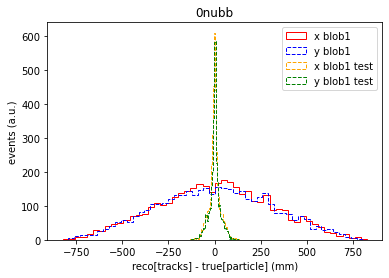

In [39]:
plt.hist(diff_b1_x_0nubb, bins = 50, color='red', histtype='step', label = 'x blob1')
plt.hist(diff_b1_y_0nubb, bins = 50, color='blue', histtype='step', label = 'y blob1', linestyle='dashed')
plt.hist(diff_b1_x_0nubb_test, bins = 50, color='orange', histtype='step', label = 'x blob1 test', linestyle='dashed')
plt.hist(diff_b1_y_0nubb_test, bins = 50, color='green', histtype='step', label = 'y blob1 test', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

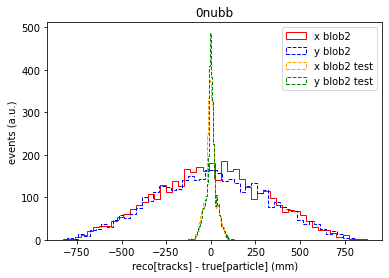

In [40]:
plt.hist(diff_b2_x_0nubb, bins = 50, color='red', histtype='step', label = 'x blob2')
plt.hist(diff_b2_y_0nubb, bins = 50, color='blue', histtype='step', label = 'y blob2', linestyle='dashed')
plt.hist(diff_b2_x_0nubb_test, bins = 50, color='orange', histtype='step', label = 'x blob2 test', linestyle='dashed')
plt.hist(diff_b2_y_0nubb_test, bins = 50, color='green', histtype='step', label = 'y blob2 test', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

In [41]:
#single electron files
true_list_selectron = []
filepath_selectron_true = filepath+'selectron/hits/'

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_selectron_true = filepath_selectron_true+f'next100.e-_roi.{nfile}.deconv.h5'

    try:
        readfile_true_selectron = pd.read_hdf(filename_selectron_true, 'MC/particles')
    except:
        print('File {} not good'.format(filename_selectron_true))
        continue
        
    true_list_selectron.append(readfile_true_0nubb)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_selectron = pd.concat([dt for dt in true_list_0nubb]) 
true_selectron.columns  

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [42]:
true_selectron_primary = true_selectron[true_selectron.primary == True]

true_selectron_primary_part1 = true_selectron_primary[true_selectron_primary.particle_id == 1]
true_selectron_primary_part2 = true_selectron_primary[true_selectron_primary.particle_id == 2]
true_selectron_primary

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
9,0,2,e-,True,0,-239.914810,-238.046280,316.365936,0.0,-200.825760,...,2.549860,0.109969,0.684162,0.0,0.0,-0.0,2.180298,235.106247,none,Scintillation
10,0,1,e-,True,0,-239.914810,-238.046280,316.365936,0.0,-240.744125,...,-0.013486,-0.226322,-0.556109,-0.0,0.0,-0.0,0.277532,17.443966,none,Scintillation
14,1,2,e-,True,0,452.146729,-166.560150,96.130058,0.0,457.095093,...,-0.406067,1.022711,0.653254,-0.0,-0.0,0.0,0.866930,63.153664,none,Scintillation
16,1,1,e-,True,0,452.146729,-166.560150,96.130058,0.0,469.336273,...,-0.455509,0.328598,-1.959947,-0.0,0.0,0.0,1.590900,56.679573,none,Scintillation
19,2,2,e-,True,0,157.780060,-127.197853,787.558777,0.0,165.998825,...,-0.259671,1.266991,-0.398611,0.0,0.0,0.0,0.935620,58.765797,none,Scintillation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,8987,1,e-,True,0,319.647125,256.603302,706.949097,0.0,292.450134,...,0.041772,0.326389,-2.535808,0.0,-0.0,0.0,2.096628,180.334976,none,Scintillation
282,8988,2,e-,True,0,-401.094818,3.905844,214.294266,0.0,-406.265930,...,0.132052,1.330568,0.311546,-0.0,-0.0,0.0,0.953934,88.180252,none,Scintillation
286,8988,1,e-,True,0,-401.094818,3.905844,214.294266,0.0,-396.048065,...,-0.084179,-1.736119,-0.881752,-0.0,-0.0,0.0,1.503896,134.865463,none,Scintillation
287,8989,2,e-,True,0,-432.714722,192.933319,1094.687134,0.0,-444.201263,...,-0.840328,0.122159,-0.132181,-0.0,0.0,-0.0,0.488834,28.419731,none,Scintillation


In [43]:
diff_b1_x_selectron, diff_b1_y_selectron, diff_b1_z_selectron = [], [], []
diff_b2_x_selectron, diff_b2_y_selectron, diff_b2_z_selectron = [], [], []

diff_b1_x_selectron_test, diff_b1_y_selectron_test, diff_b1_z_selectron_test = [], [], []
diff_b2_x_selectron_test, diff_b2_y_selectron_test, diff_b2_z_selectron_test = [], [], []

#[0] e_reco, [1] e_blob1, [2] e_blob2
reco_selectron_e, reco_selectron_e_track, reco_selectron_e_blob1, reco_selectron_e_blob2 = [], [], [], []

totalevents, events12AB, events12BA, eventsNA = 0, 0, 0, 0

direction12, direction21 = False, False

for nevt in range(1,true_selectron.event_id.nunique()):
    
    if nevt not in tracks_selectron_ROIovlp1trackfid.event.unique():
        continue
    if nevt not in true_selectron_primary_part1.event_id.unique():
        continue
        
    true_selectron_x_pA = float(true_selectron_primary_part1[true_selectron_primary_part1.event_id == nevt].initial_x.values)
    true_selectron_y_pA = float(true_selectron_primary_part1[true_selectron_primary_part1.event_id == nevt].initial_x.values)
    true_selectron_z_pA = float(true_selectron_primary_part1[true_selectron_primary_part1.event_id == nevt].initial_x.values)

    true_selectron_x_pB = float(true_selectron_primary_part1[true_selectron_primary_part1.event_id == nevt].final_x.values)
    true_selectron_y_pB = float(true_selectron_primary_part1[true_selectron_primary_part1.event_id == nevt].final_y.values)
    true_selectron_z_pB = float(true_selectron_primary_part1[true_selectron_primary_part1.event_id == nevt].final_z.values)
    
    
    reco_selectron_x_blobA = float(tracks_selectron_ROIovlp1trackfid[tracks_selectron_ROIovlp1trackfid.event == nevt].blob1_x.values)
    reco_selectron_y_blobA = float(tracks_selectron_ROIovlp1trackfid[tracks_selectron_ROIovlp1trackfid.event == nevt].blob1_y.values)
    reco_selectron_z_blobA = float(tracks_selectron_ROIovlp1trackfid[tracks_selectron_ROIovlp1trackfid.event == nevt].blob1_z.values)
    
    reco_selectron_x_blobB = float(tracks_selectron_ROIovlp1trackfid[tracks_selectron_ROIovlp1trackfid.event == nevt].blob2_x.values)
    reco_selectron_y_blobB = float(tracks_selectron_ROIovlp1trackfid[tracks_selectron_ROIovlp1trackfid.event == nevt].blob2_y.values)
    reco_selectron_z_blobB = float(tracks_selectron_ROIovlp1trackfid[tracks_selectron_ROIovlp1trackfid.event == nevt].blob2_z.values)
    
    reco_selectron_e_blobA = float(tracks_selectron_ROIovlp1trackfid[tracks_selectron_ROIovlp1trackfid.event == nevt].eblob1.values)
    reco_selectron_e_blobB = float(tracks_selectron_ROIovlp1trackfid[tracks_selectron_ROIovlp1trackfid.event == nevt].eblob2.values)
    
    reco_selectron_e_track.append(float(tracks_selectron_ROIovlp1trackfid[tracks_selectron_ROIovlp1trackfid.event == nevt].energy.values))
    
    R_12 = math.sqrt((true_selectron_x_pB-true_selectron_x_pA)**2+(true_selectron_y_pB-true_selectron_y_pA)**2+(true_selectron_z_pB-true_selectron_z_pA)**2)/2
    R_AB = math.sqrt((reco_selectron_x_blobA-reco_selectron_x_blobB)**2+(reco_selectron_y_blobA-reco_selectron_y_blobB)**2+(reco_selectron_z_blobA-reco_selectron_z_blobB)**2)/2
    d_A1 = math.sqrt((true_selectron_x_pA-reco_selectron_x_blobA)**2+(true_selectron_y_pA-reco_selectron_y_blobA)**2+(true_selectron_z_pA-reco_selectron_z_blobA)**2)
    d_B1 = math.sqrt((true_selectron_x_pA-reco_selectron_x_blobB)**2+(true_selectron_y_pA-reco_selectron_y_blobB)**2+(true_selectron_z_pA-reco_selectron_z_blobB)**2)
    d_A2 = math.sqrt((true_selectron_x_pB-reco_selectron_x_blobA)**2+(true_selectron_y_pB-reco_selectron_y_blobA)**2+(true_selectron_z_pB-reco_selectron_z_blobA)**2)
    d_B2 = math.sqrt((true_selectron_x_pB-reco_selectron_x_blobB)**2+(true_selectron_y_pB-reco_selectron_y_blobB)**2+(true_selectron_z_pB-reco_selectron_z_blobB)**2)
    
    diff_b1_x_selectron.append(reco_selectron_x_blobA - true_selectron_x_pA)
    diff_b1_y_selectron.append(reco_selectron_y_blobA - true_selectron_y_pA)
    
    diff_b2_x_selectron.append(reco_selectron_x_blobB - true_selectron_x_pB)
    diff_b2_y_selectron.append(reco_selectron_y_blobB - true_selectron_y_pB)
    
    #print(f'R_12 = {R_12}')
    #print(f'R_AB = {R_AB}')
    #print(f'd_A1 = {d_A1}')
    #print(f'd_A2 = {d_A2}')
    #print(f'd_B1 = {d_B1}')
    #print(f'd_B2 = {d_B2}')
    
    totalevents = totalevents+1

    
    if abs(d_A1<R_12) or abs(d_B2<R_12):
        events12AB = events12AB+1
        direction12 = True
        #print('direction A1 B2')
    elif abs(d_A2<R_12) or abs(d_B1<R_12):
        events12BA = events12BA+1
        #print('direction A2 B1')
        direction21 = True
    elif d_A1<d_B1 and d_A2 and d_B2:
        events12AB = events12AB+1
        #print('direction A1 B2')
        direction12 = True
    elif d_B2<d_B1 and d_A2 and d_A1:
        events12AB = events12AB+1
        #print('direction A1 B2')
        direction12 = True
    elif d_A2<d_B1 and d_A1 and d_B2:
        events12BA = events12BA+1
        #print('direction A2 B1')
        direction21 = True
    elif d_B1<d_B2 and d_A1 and d_A2:
        events12BA = events12BA+1
        direction21 = True
        #print('direction A2 B1')
    else:
        eventsNA = eventsNA+1
        
    if (direction12 == True) & (reco_selectron_e_blobA > reco_selectron_e_blobB):
        reco_selectron_x_blob1 = reco_selectron_x_blobA
        reco_selectron_y_blob1 = reco_selectron_y_blobA
        reco_selectron_z_blob1 = reco_selectron_z_blobA
        
        reco_selectron_x_blob2 = reco_selectron_x_blobB
        reco_selectron_y_blob2 = reco_selectron_y_blobB
        reco_selectron_z_blob2 = reco_selectron_z_blobB
    
        true_selectron_x_p1 = true_selectron_x_pA
        true_selectron_y_p1 = true_selectron_y_pA
        true_selectron_z_p1 = true_selectron_z_pA
        
        true_selectron_x_p2 = true_selectron_x_pB
        true_selectron_y_p2 = true_selectron_y_pB
        true_selectron_z_p2 = true_selectron_z_pB
        
        reco_selectron_e_blob1.append(reco_selectron_e_blobA)
        reco_selectron_e_blob2.append(reco_selectron_e_blobB)

    elif (direction12 == True) & (reco_selectron_e_blobA < reco_selectron_e_blobB):
        reco_selectron_x_blob2 = reco_selectron_x_blobA
        reco_selectron_y_blob2 = reco_selectron_y_blobA
        reco_selectron_z_blob2 = reco_selectron_z_blobA
        
        reco_selectron_x_blob1 = reco_selectron_x_blobB
        reco_selectron_y_blob1 = reco_selectron_y_blobB
        reco_selectron_z_blob1 = reco_selectron_z_blobB
    
        true_selectron_x_p2 = true_selectron_x_pA
        true_selectron_y_p2 = true_selectron_y_pA
        true_selectron_z_p2 = true_selectron_z_pA
        
        true_selectron_x_p1 = true_selectron_x_pB
        true_selectron_y_p1 = true_selectron_y_pB
        true_selectron_z_p1 = true_selectron_z_pB
        
        reco_selectron_e_blob1.append(reco_selectron_e_blobB)
        reco_selectron_e_blob2.append(reco_selectron_e_blobA)
        
    elif (direction21 == True) & (reco_selectron_e_blobA > reco_selectron_e_blobB):
        reco_selectron_x_blob2 = reco_selectron_x_blobB
        reco_selectron_y_blob2 = reco_selectron_y_blobB
        reco_selectron_z_blob2 = reco_selectron_z_blobB
        
        reco_selectron_x_blob1 = reco_selectron_x_blobA
        reco_selectron_y_blob1 = reco_selectron_y_blobA
        reco_selectron_z_blob1 = reco_selectron_z_blobA
        
        true_selectron_x_p2 = true_selectron_x_pA
        true_selectron_y_p2 = true_selectron_y_pA
        true_selectron_z_p2 = true_selectron_z_pA
        
        true_selectron_x_p1 = true_selectron_x_pB
        true_selectron_y_p1 = true_selectron_y_pB
        true_selectron_z_p1 = true_selectron_z_pB
        
        reco_selectron_e_blob1.append(reco_selectron_e_blobA)
        reco_selectron_e_blob2.append(reco_selectron_e_blobB)
        
    elif (direction21 == True) & (reco_selectron_e_blobA < reco_selectron_e_blobB):
        reco_selectron_x_blob1 = reco_selectron_x_blobB
        reco_selectron_y_blob1 = reco_selectron_y_blobB
        reco_selectron_z_blob1 = reco_selectron_z_blobB
        
        reco_selectron_x_blob2 = reco_selectron_x_blobA
        reco_selectron_y_blob2 = reco_selectron_y_blobA
        reco_selectron_z_blob2 = reco_selectron_z_blobA
        
        true_selectron_x_p1 = true_selectron_x_pA
        true_selectron_y_p1 = true_selectron_y_pA
        true_selectron_z_p1 = true_selectron_z_pA
        
        true_selectron_x_p2 = true_selectron_x_pB
        true_selectron_y_p2 = true_selectron_y_pB
        true_selectron_z_p2 = true_selectron_z_pB
        
        reco_selectron_e_blob1.append(reco_selectron_e_blobB)
        reco_selectron_e_blob2.append(reco_selectron_e_blobA)
        
    diff_b1_x_selectron_test.append(reco_selectron_x_blob1 - true_selectron_x_p1)
    diff_b1_y_selectron_test.append(reco_selectron_y_blob1 - true_selectron_y_p1)
    
    diff_b2_x_selectron_test.append(reco_selectron_x_blob2 - true_selectron_x_p2)
    diff_b2_y_selectron_test.append(reco_selectron_y_blob2 - true_selectron_y_p2)
    direction12, direction21 = False, False
    

        
reco_selectron_e_blob1 = np.array(reco_selectron_e_blob1, dtype=np.float)
reco_selectron_e_blob2 = np.array(reco_selectron_e_blob2, dtype=np.float)
reco_selectron_e_track = np.array(reco_selectron_e_track, dtype=np.float)

reco_selectron_e.append(reco_selectron_e_track)
reco_selectron_e.append(reco_selectron_e_blob1)
reco_selectron_e.append(reco_selectron_e_blob2)

print(f'Total events = {totalevents}')
print(f'Events 12 = {events12AB} ({100*events12AB/totalevents}%)')
print(f'Events 21 = {events12BA} ({100*events12BA/totalevents}%)')
print(f'Events NA = {eventsNA} ({100*eventsNA/totalevents}%)')

Total events = 3678
Events 12 = 3172 (86.24252311038607%)
Events 21 = 506 (13.75747688961392%)
Events NA = 0 (0.0%)


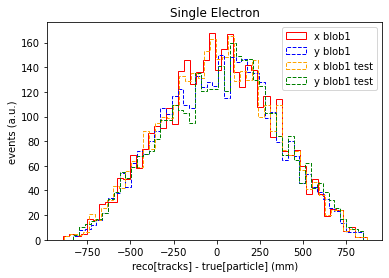

In [44]:
plt.hist(diff_b1_x_selectron, bins = 50, color='red', histtype='step', label = 'x blob1')
plt.hist(diff_b1_y_selectron, bins = 50, color='blue', histtype='step', label = 'y blob1', linestyle='dashed')
plt.hist(diff_b1_x_selectron_test, bins = 50, color='orange', histtype='step', label = 'x blob1 test', linestyle='dashed')
plt.hist(diff_b1_y_selectron_test, bins = 50, color='green', histtype='step', label = 'y blob1 test', linestyle='dashed')
        
plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

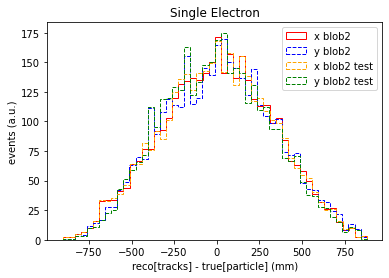

In [45]:
plt.hist(diff_b2_x_selectron, bins = 50, color='red', histtype='step', label = 'x blob2')
plt.hist(diff_b2_y_selectron, bins = 50, color='blue', histtype='step', label = 'y blob2', linestyle='dashed')
plt.hist(diff_b2_x_selectron_test, bins = 50, color='orange', histtype='step', label = 'x blob2 test', linestyle='dashed')
plt.hist(diff_b2_y_selectron_test, bins = 50, color='green', histtype='step', label = 'y blob2 test', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

### 2 - BLOB energy distributions for SIGNAL and BACKGROUND

After properly asigning blob1 and 2 tags, it's straigh forward to represent the energy distributions for the signal and background events:

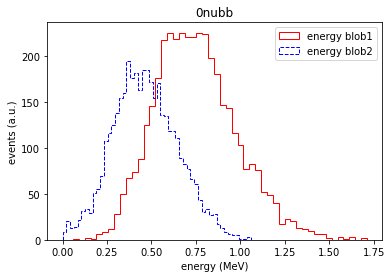

In [46]:
plt.hist(reco_0nubb_e_blob1, bins = 50, color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_0nubb_e_blob2, bins = 50, color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

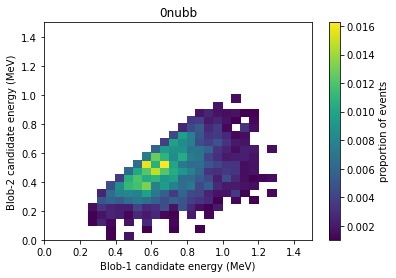

In [47]:
weights = myhf.get_weights(reco_0nubb_e_blob1, True)


plt.hist2d(reco_0nubb_e_blob1, reco_0nubb_e_blob2, weights= weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob-1 candidate energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

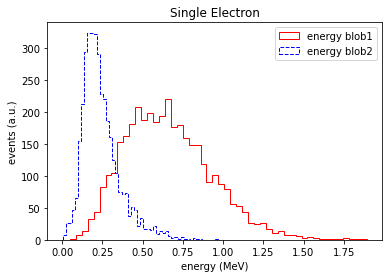

In [48]:
plt.hist(reco_selectron_e_blob1, bins = 50, color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_selectron_e_blob2, bins = 50, color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

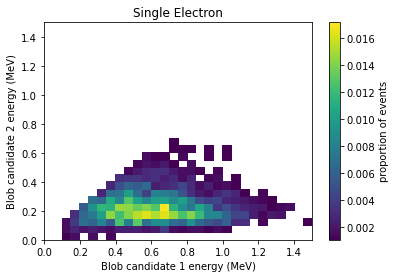

In [49]:
weights = myhf.get_weights(reco_selectron_e_blob1, True)

plt.hist2d(reco_selectron_e_blob1, reco_selectron_e_blob2, weights=weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob candidate 1 energy (MeV)')
plt.ylabel('Blob candidate 2 energy (MeV)')
plt.title('Single Electron')
plt.colorbar(label='proportion of events')

### 3 - Efficiency Values and fom estimation

First of all I'm going to check how blob energies are distributed acording to the track energy.

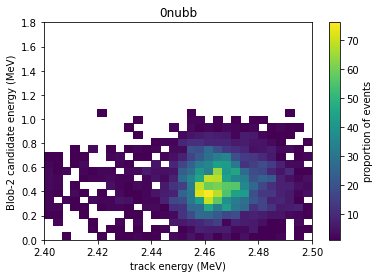

In [50]:
plt.hist2d(reco_0nubb_e_track, reco_0nubb_e_blob2, bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

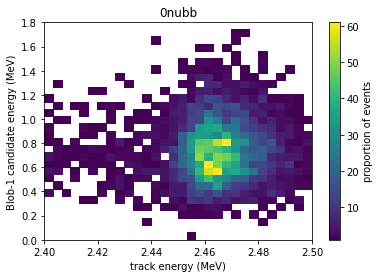

In [51]:
plt.hist2d(reco_0nubb_e_track, reco_0nubb_e_blob1, bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-1 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

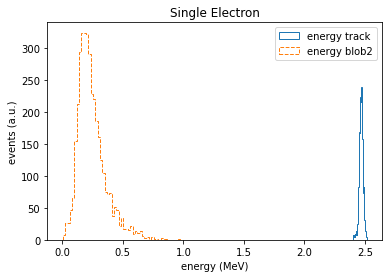

In [52]:
plt.hist(reco_selectron_e_track, bins = 50, histtype='step', label = 'energy track')
plt.hist(reco_selectron_e_blob2, bins = 50, histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

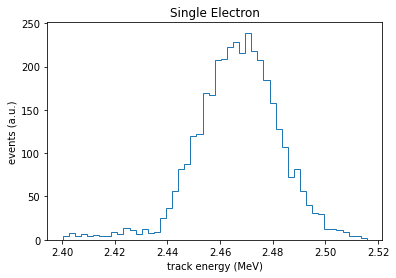

Total events 3678


In [53]:
plt.hist(reco_selectron_e_track, bins = 50, histtype='step', label = 'energy track')
plt.xlabel('track energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.show()

print(f'Total events {len(reco_selectron_e_track)}')

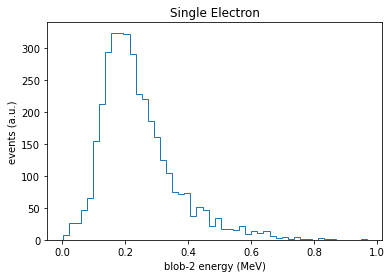

Total events 3678


In [54]:
plt.hist(reco_selectron_e_blob2, bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.show()

print(f'Total events {len(reco_selectron_e_track)}')

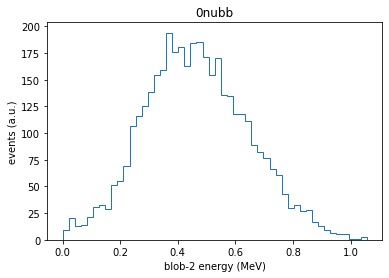

Total events 3678


In [55]:
plt.hist(reco_0nubb_e_blob2, bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

print(f'Total events {len(reco_selectron_e_track)}')

In the following boxes I'm going to define the functions I'm going to use to do the full efficiency/fom analysis:

In [56]:
blobcut_energy=[]
#in MeV
minEcut = 0.010
maxEcut = 0.600
stepsEcut = 0.010

blobcut_energy=myef.blobthreshold(minEcut,maxEcut,stepsEcut)

Now I'm going to take the information from reco_selectron_e[][], to see how many events with each cut I get:

In [57]:
blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron = [], [] 

blobcut_energy_nevents_0nubb = myef.nevents_afterthreshold(blobcut_energy, reco_0nubb_e)
blobcut_energy_nevents_selectron = myef.nevents_afterthreshold(blobcut_energy, reco_selectron_e)

blobcut_energy_nevents_0nubb = np.array(blobcut_energy_nevents_0nubb, dtype=np.float)
blobcut_energy_nevents_selectron = np.array(blobcut_energy_nevents_selectron, dtype=np.float)

Create now arrays containing the statistical uncertainty (sqrt from total amount of events)

In [58]:
blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error= [], []

blobcut_energy_nevents_0nubb_error = myef.sqrterror_array(blobcut_energy_nevents_0nubb)
blobcut_energy_nevents_selectron_error = myef.sqrterror_array(blobcut_energy_nevents_selectron)

Text(0.5, 0, 'blob-2 energy threshold (MeV)')

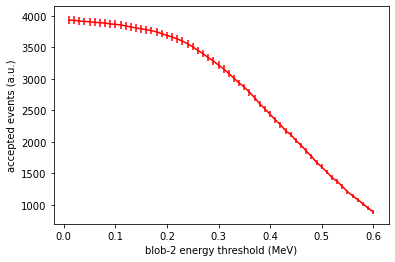

In [59]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,blobcut_energy_nevents_0nubb, yerr=blobcut_energy_nevents_0nubb_error, fmt = '-r')
plt.ylabel('accepted events (a.u.)')
plt.xlabel('blob-2 energy threshold (MeV)')
#plt.title('Cut efficiency')

In [60]:
fom_error, e_error, b_error = [], [], []

e, b, fom, e_error, b_error, fom_error = myef.efficiencyterms(blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron, 
                            blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error,
                            reco_0nubb_e, reco_selectron_e)

Text(0.5, 0, 'background rejection')

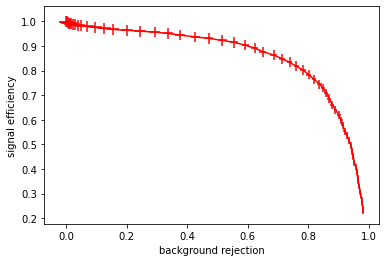

In [61]:
fig, ax = plt.subplots()
ax.errorbar(1-b,e, xerr=b_error, yerr=e_error, fmt = '-r')
plt.ylabel('signal efficiency')
plt.xlabel('background rejection')
#plt.title('Cut efficiency')

Text(0, 0.5, 'f.o.m.=e/sqrt(b)')

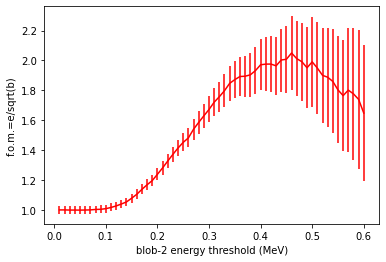

In [62]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,fom, yerr=fom_error,fmt = '-r')
plt.xlabel('blob-2 energy threshold (MeV)')
plt.ylabel('f.o.m.=e/sqrt(b)')
#plt.title('Cut efficiency')

In [63]:
myef.best_fom(e,b,fom,blobcut_energy)

Best fom is {2.049683107809497}, that corresponds to:
- signal efficiency of 49.44%
- background acceptance of 5.82%
- energy threshold of 0.46 MeV
